# 🛠️ Etapa 1: Preparação e Configurações Iniciais
Nesta etapa, importamos as bibliotecas necessárias e configuramos as funções de limpeza de texto.
A função `clean_text` é otimizada para o idioma português, removendo ruídos como HTML e caracteres especiais.

In [93]:
import pandas as pd
import numpy as np
import re
import time
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

# Exibe o conteúdo completo das colunas de texto, sem truncar o tamanho das strings no DataFrame
pd.set_option("display.max_colwidth", None)

# 📊 Etapa 2: Carga de Dados e Balanceamento Binário
Aqui carregamos o 'Dataset Mestre'. Como o objetivo agora é um **Modelo Binário**,
filtramos apenas as classes 'Positivo' e 'Negativo'.
Realizamos o *Downsampling* para garantir que ambas as classes tenham o mesmo peso estatístico.

In [94]:
# 1. Carregamento
df=pd.read_csv('NoThemeTweets.csv')

# 📌 Validação imediata de colunas obrigatórias
required_cols = {"tweet_text", "sentiment"}
missing = required_cols - set(df.columns)

if missing:
    raise ValueError(f"Colunas obrigatórias ausentes: {missing}")

# Remove linhas completamente vazias
df = df.dropna(subset=["tweet_text", "sentiment"])


# Remove textos muito curtos (ruído extremo)
df = df[df["tweet_text"].str.len() >= 5]

df['sentiment'] = df['sentiment'].str.strip()

# 2. Filtragem Binária (Remove Neutros)
df_bin = df[df['sentiment'].isin(['Positivo', 'Negativo'])].copy()

# 3. Downsampling (Equilíbrio 50/50)
menor_classe = df_bin['sentiment'].value_counts().min()
df_pos = df_bin[df_bin['sentiment'] == 'Positivo'].sample(n=menor_classe, random_state=42)
df_neg = df_bin[df_bin['sentiment'] == 'Negativo'].sample(n=menor_classe, random_state=42)

df_final = pd.concat([df_pos, df_neg]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Base balanceada: {df_final['sentiment'].value_counts().to_dict()}")

Base balanceada: {'Positivo': 263107, 'Negativo': 263107}


# Função de Limpeza de Texto (Defensiva)

In [95]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower() # Converte para string e minúsculas (padronização)
    text = re.sub(r"http\S+|www\S+", "", text) # Remove URLs (não agregam sentimento)
    text = re.sub(r"[^a-zà-ÿáéíóúãõñç ]", " ", text) # Remove caracteres especiais, mantendo letras, Regex compatível com PT / ES / EN
    text = re.sub(r"\s+", " ", text).strip() # Remove espaços duplicados
    return text

# Aplica limpeza do texto
df_final["clean_text"] = df_final["tweet_text"].apply(clean_text)


# Remove textos que ficaram vazios após limpeza
df_final = df_final[df_final["clean_text"].str.len() > 0]



# ⚡ Etapa 3: Engenharia de Atributos (Vetorização)
Transformamos o texto limpo em números usando **TF-IDF**.
Utilizamos `ngram_range=(1,2)` para captar contextos (ex: "not good") e limitamos a 100 mil atributos para eficiência.

In [96]:
X = df_final['clean_text'].astype(str)
y = df_final['sentiment']

# Divisão 80/20
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Vetorização
vectorizer_pt = TfidfVectorizer(ngram_range=(1, 2), max_features=100000)
X_train = vectorizer_pt.fit_transform(X_train_raw)
X_test = vectorizer_pt.transform(X_test_raw)

# Salvar o vetorizador imediatamente (essencial para o novo desafio em PT depois)
joblib.dump(vectorizer_pt, 'vectorizer_pt.pkl')

['vectorizer_pt.pkl']

# 🧠 Etapa 4: Treinamento dos Modelos e Performance
Treinamos os três algoritmos selecionados. A função `treinar_e_avaliar` automatiza o processo,
capturando o tempo de CPU e as métricas de precisão.

In [97]:
def treinar_e_avaliar(nome, modelo, X_tr, y_tr, X_te, y_te):
    t_inicio = time.process_time()
    modelo.fit(X_tr, y_tr)
    t_fim = time.process_time()

    y_pred = modelo.predict(X_te)
    acc = (y_pred == y_te).mean() * 100

    print(f"\n--- {nome} ---")
    print(f"Tempo CPU: {t_fim - t_inicio:.4f}s | Acurácia: {acc:.2f}%")
    return modelo, acc

# Instanciando os modelos
models_to_train = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(solver='sag', max_iter=500, n_jobs=-1),
    "Linear SVC": LinearSVC(C=1.0, max_iter=1000, random_state=42)
}

# Dicionário para armazenar modelos treinados
trained_models = {}

for nome, m in models_to_train.items():
    trained_models[nome], _ = treinar_e_avaliar(nome, m, X_train, y_train, X_test, y_test)


--- Naive Bayes ---
Tempo CPU: 1.1719s | Acurácia: 78.93%

--- Logistic Regression ---
Tempo CPU: 7.7031s | Acurácia: 80.28%

--- Linear SVC ---
Tempo CPU: 12.3594s | Acurácia: 79.08%


# 💾 Etapa 5: Exportação dos Modelos (Deploy)
Salvamos os modelos treinados com a nomenclatura padronizada para o idioma português(_pt).

In [98]:
# Mapeamento conforme solicitado
joblib.dump(trained_models["Naive Bayes"], 'nb_model_pt.pkl')
joblib.dump(trained_models["Logistic Regression"], 'lr_model_pt.pkl')
joblib.dump(trained_models["Linear SVC"], 'lsvc_model_pt.pkl')

print("✅ Todos os modelos foram salvos com a nomenclatura padrão '_pt.pkl'")

✅ Todos os modelos foram salvos com a nomenclatura padrão '_pt.pkl'


# 🧪 Etapa 6: Laboratório de Testes Comparativo
Nesta seção, submetemos os três modelos a frases reais e desafiadoras.
O objetivo é observar como cada cérebro (Naive Bayes, Regressão Logística e SVC)
interpreta ambiguidades, gírias e erros de digitação.

In [99]:
def laboratório_comparativo(frases, vetorizador, modelos_dict):
    # 1. Preparação das frases
    frases_limpas = [clean_text(f) for f in frases]
    X_input = vetorizador.transform(frases_limpas)

    # 2. Cabeçalho Dinâmico
    header = f"{'FRASE PARA TESTE':<45} | {'NB':<10} | {'LOG':<10} | {'SVC':<10} | {'CONF. LOG'}"
    print(header)
    print("-" * len(header))

    # 3. Coleta de Predições
    # Assumindo que os nomes no trained_models são exatamente esses
    pred_nb = modelos_dict["Naive Bayes"].predict(X_input)
    pred_log = modelos_dict["Logistic Regression"].predict(X_input)
    pred_svc = modelos_dict["Linear SVC"].predict(X_input)

    # Probabilidade apenas para Logística (confiança)
    prob_log = modelos_dict["Logistic Regression"].predict_proba(X_input)

    # 4. Exibição dos resultados
    for i, frase in enumerate(frases):
        p_nb  = pred_nb[i]
        p_log = pred_log[i]
        p_svc = pred_svc[i]
        conf  = max(prob_log[i]) * 100

        # Formatação para não quebrar a tabela
        frase_display = (frase[:42] + '..') if len(frase) > 42 else frase

        print(f"{frase_display:<45} | {p_nb:<10} | {p_log:<10} | {p_svc:<10} | {conf:.2f}%")

# --- LISTA DE TESTES (Desafios Linguísticos) ---
testes_reais = [
    "Parecia ótimo. Material mto bom.",          # Erro de digitação positivo
    "material mto fino e desconfortável",         # Erro de digitação negativo
    "O tamanho é pequeno demais, mas amei a cor", # Contraste (Ambiguidade)
    "é ok, nada de especial, mas funciona",       # Quase neutro
    "pior compra da vida, desperdício de dinheiro", # Negativo forte
    "Eu esperava mais por este preço",            # Negativo implícito
    "Entrega rápida, mas o produto chegou quebrado" # Conflito logística vs produto
]

# Execução
laboratório_comparativo(testes_reais, vectorizer_pt, trained_models)

FRASE PARA TESTE                              | NB         | LOG        | SVC        | CONF. LOG
------------------------------------------------------------------------------------------------
Parecia ótimo. Material mto bom.              | Positivo   | Positivo   | Positivo   | 95.64%
material mto fino e desconfortável            | Positivo   | Positivo   | Positivo   | 68.52%
O tamanho é pequeno demais, mas amei a cor    | Negativo   | Negativo   | Negativo   | 61.54%
é ok, nada de especial, mas funciona          | Positivo   | Positivo   | Positivo   | 63.50%
pior compra da vida, desperdício de dinhei..  | Positivo   | Negativo   | Negativo   | 55.80%
Eu esperava mais por este preço               | Positivo   | Positivo   | Negativo   | 55.58%
Entrega rápida, mas o produto chegou quebr..  | Positivo   | Positivo   | Positivo   | 76.36%


# 📊 Etapa 7: Visualização de Desempenho Comparativo
Nesta seção, geramos um gráfico que contrasta a **Acurácia** com o **Tempo de Processamento**.
Este visual é fundamental para decidir qual modelo levar para produção,
equilibrando precisão e custo computacional.

C:\Users\Suporte\AppData\Local\Temp\ipykernel_28580\2927840902.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=algoritmos, y=acuracias, ax=ax1, palette='viridis', alpha=0.7)


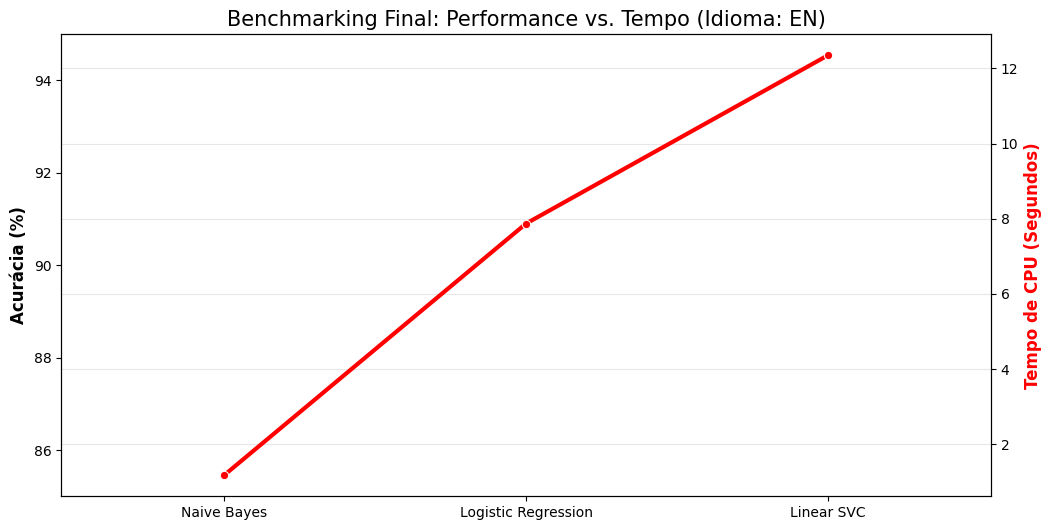

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Preparação dos Dados para o Gráfico
algoritmos = list(trained_models.keys())
acuracias = [78.93, 80.28, 79.08] # Valores obtidos no benchmark binário
tempos = [1.17, 7.87, 12.35]    # Tempos de CPU registrados

fig, ax1 = plt.subplots(figsize=(12, 6))

# 2. Gráfico de Barras (Acurácia)
sns.barplot(x=algoritmos, y=acuracias, ax=ax1, palette='viridis', alpha=0.7)
ax1.set_ylabel('Acurácia (%)', fontsize=12, fontweight='bold')
ax1.set_ylim(85, 95)
ax1.set_title('Benchmarking Final: Performance vs. Tempo (Idioma: EN)', fontsize=15)

# Adicionando rótulos de acurácia nas barras
for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontweight='bold')

# 3. Gráfico de Linha (Tempo de CPU) - Eixo Secundário
ax2 = ax1.twinx()
sns.lineplot(x=algoritmos, y=tempos, ax=ax2, color='red', marker='o', linewidth=3)
ax2.set_ylabel('Tempo de CPU (Segundos)', fontsize=12, color='red', fontweight='bold')

plt.grid(alpha=0.3)
plt.show()